In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack 
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score, roc_auc_score

import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers  import Conv1D  
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers  import MaxPooling1D

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, GRU, SimpleRNN 

# DATASET PROCESSING

In [2]:
# load a single file as a numpy array
def load_file(filepath): 
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values 

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
        
	# stack group so that features are the 3rd dimension
	loaded = np.concatenate(loaded)
	return loaded     

In [4]:
# load a dataset group, such as train or test
def load_dataset_group():
	filepath = "C:\\Users\\vvsat\\Documents\\machine learning\\gait parkinsons\\binary classification\\dataset\\dataset\\"
    
	# load all files as a single array
	filenames = list()
    
	filenames = ['co.txt', 'pd.txt'] 
    
	# load input data
	X = load_group(filenames, filepath)
    
    
	# load class output
	# load input data
	y = load_file("C:\\Users\\vvsat\\Documents\\machine learning\\gait parkinsons\\binary classification\\dataset\\dataset\\target.txt")
	return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    
	X, y = load_dataset_group()
	print(X.shape, y.shape) 
       
	# load all train
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=27) 
    
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
    
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
    
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

# MODEL BUILDING

In [6]:
# load data
trainX, trainy, testX, testy = load_dataset()
    
verbose, epochs, batch_size = 0, 10, 32
n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainy.shape[0]
print(n_timesteps, n_features, n_outputs)
   
print("trainX shape : ",trainX.shape)
print("trainy shape : ",trainy.shape)  
    
#Build the LSTM model 
# LSTM Layer returns whole_seq_output, final_memory_state, and final_carry_state 
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(None, 1)))
model.add(LSTM(128, return_sequences= True))
model.add(LSTM(256, return_sequences= False))  
    
model.add(Dropout(rate = 0.5)) 
 
model.add(Dense(2)) 
model.summary()  

# learning rate decay
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile the model 
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  

(3317550, 18) (3317550, 1)
(2488162, 18) (2488162, 2) (829388, 18) (829388, 2)
2488162 18 2488162
trainX shape :  (2488162, 18)
trainy shape :  (2488162, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 510,466
Trainable

   # TRAINING THE  MODEL  WITH LSTM

In [7]:
#fitting the model  
history = model.fit(trainX, 
                    trainy, 
                    epochs=5,
                    batch_size=800,
                    validation_split=0.2,
                    verbose=1)           

Epoch 1/5
2489/2489 [==============================] - 54s 19ms/step - loss: 0.4485 - accuracy: 0.7866 - val_loss: 0.2927 - val_accuracy: 0.8732
Epoch 2/5
2489/2489 [==============================] - 45s 18ms/step - loss: 0.2169 - accuracy: 0.9108 - val_loss: 0.1663 - val_accuracy: 0.9336
Epoch 3/5
2489/2489 [==============================] - 46s 18ms/step - loss: 0.1297 - accuracy: 0.9502 - val_loss: 0.1039 - val_accuracy: 0.9608
Epoch 4/5
2489/2489 [==============================] - 46s 18ms/step - loss: 0.0934 - accuracy: 0.9648 - val_loss: 0.0819 - val_accuracy: 0.9693
Epoch 5/5
2489/2489 [==============================] - 46s 19ms/step - loss: 0.0750 - accuracy: 0.9721 - val_loss: 0.0753 - val_accuracy: 0.9718


# SAVING THE MODEL

In [8]:
model.save('binary_lstm.h5') 

In [7]:
model = tf.keras.models.load_model('binary_lstm.h5')

# PLOTTING THE METRICS

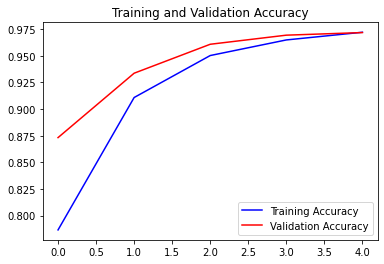

<Figure size 432x288 with 0 Axes>

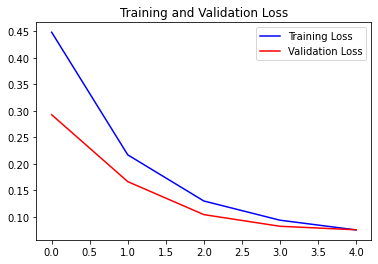

In [9]:
train_acc = history.history['accuracy'] 
train_loss = history.history['loss'] 
val_acc = history.history['val_accuracy'] 
val_loss = history.history['val_loss']

epochs = range(len(train_acc))  

plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

# MODEL EVALUATION

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(testX, testy, batch_size=800)
print("test loss, test acc:", results) 

Evaluate on test data
1037/1037 [==============================] - 9s 7ms/step - loss: 0.0759 - accuracy: 0.9712
test loss, test acc: [0.07589971274137497, 0.9711666703224182]


In [9]:
y_pred = model.predict(testX) 
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(testy, axis=1) 

# CONFUSION MATRIX

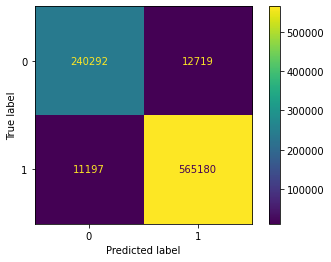

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show() 

# DISPLAYING PRECISION, RECALL AND AUC

In [13]:
print('precision score : ', precision_score(y_test, y_pred, average = 'micro'),
      '\n', 'recall score : ', recall_score(y_test, y_pred, average = 'micro'))

precision score :  0.9711642801680275 
 recall score :  0.9711642801680275


In [10]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr) 
roc_auc

0.9651514686099053

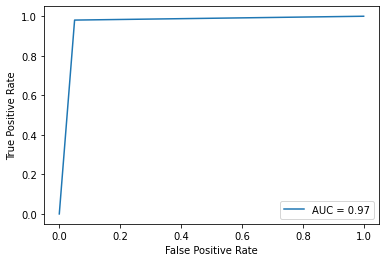

In [11]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()